In [1]:
# ETAPA DE PREPARAÇÃO DO PYTHON 
from pyfirmata import Arduino,util                     # para interagir com Arduino (controle do Arduino)
import pandas as pd                                    # para análise e manipulação de dados
from sklearn.preprocessing import MinMaxScaler         # para manipulação de dados (normalização)
from sklearn.model_selection import train_test_split   # para  preparar dados para treinamento e teste
from sklearn.ensemble import RandomForestClassifier    # para o modelo de ML (aprendizado supervisionado)
from sklearn.metrics import accuracy_score, confusion_matrix # para avaliar o modelo de ML
import matplotlib.pyplot as plt                              # para criar visualizações e gráficos
import time                                                  # para funções e métodos relacionados ao tempo

In [2]:
# ETAPA DE PREPARAÇÃO DO ARDUINO

#Abre a comunicação com a placa Arduino 
port = '/dev/cu.usbmodem14701'  # ou a porta correta do seu Arduino (no Windows 'COM1', por exemplo)

placa = Arduino(port)           #assim "placa" representa o objeto Arduino (instância de uma classe) 

In [3]:
# Ativa a interação com a placa , isto evita o transbordamento da porta serial (de 64 bytes)
it = util.Iterator(placa) # usada para "ouvir" os eventos (de forma assíncrona) 
it.start()                # gerados pelo Arduino, como leituras de sensores, estados de pinos, etc.

In [4]:
# Configuração do hardware do Arduino (Escolha e configuração de pinos, ...)

# Configura os pinos dos LDRs e do botão
ldr1 = 0
ldr2 = 1
ldr3 = 2  # Pinos analógicos (A0,A1 e A2) onde os LDRs estão conectados

placa.analog[ldr1].enable_reporting()  # Habilita leitura do pino analógico
placa.analog[ldr2].enable_reporting()  # Habilita leitura do pino analógico
placa.analog[ldr3].enable_reporting()  # Habilita leitura do pino analógico

# Configura o botão (pino digital 2) como entrada digital e habilita sua leitura

botao = placa.get_pin('d:2:i')
botao.enable_reporting()

# Configuração do servo motor

servo_pin = 9   # Configura o pino para controle do servo
meu_servo = placa.get_pin("d:{0}:s".format(servo_pin))  # assim, meu_servo representa o servo


In [5]:
# ETAPA DE CAPTURA DOS DADOS PARA POSTERIOR TREINAMENTO DO ML

# Seção do algoritmo para interagir com o Arduino, capturar dados, montar matriz,...

# Variável para rastrear o estado atual do botão (ligado/desligado)
estado_botao = True  # Inicia o botão na leitura "dia"
estado_anterior = False # O estado anterior do botão é "noite"

# Leitura dos dados na serial do Arduino, construindo uma matriz com os 
# valores dos pinos analógicos (ldr1,ldr2,ldr3) e o estado (dia/noite) em cada linha

try:
    data_matrix = []  # Matriz para armazenar os dados
    max_lines = 120  # Número máximo de linhas a serem lidas
    lines_collected = 0  # Inicializa contador de linhas
    pause_interval = 20  # Define o intervalo para pausa (por exemplo, a cada 20 linhas)

    while len(data_matrix) < max_lines:
        time.sleep(.1)

        # Lê os valores dos LDRs (0,1023) -> normalizados para (0,1) no Python
        ldr1_valor = placa.analog[ldr1].read()  #leitura do pino do ldr1 
        ldr2_valor = placa.analog[ldr2].read()  #leitura do pino do ldr2
        ldr3_valor = placa.analog[ldr3].read()  #leitura do pino do ldr3

        estado_atual = botao.read()
        if estado_atual and not estado_anterior:
            meu_servo.write(0)  # move o servo para a posição 0 graus (dia)
            estado_botao = not estado_botao  # inverte o estado do botão
            time.sleep(.2)  # adiciona um pequeno atraso para dar tempo para tirar o dedo do botão
        elif not estado_botao:
            meu_servo.write(180)  # move o servo para a posição 180 graus (noite)
            time.sleep(.2)

        estado_anterior = estado_atual
        # Adiciona os dados à matriz
        data_matrix.append([ldr1_valor, ldr2_valor, ldr3_valor, 'dia' if estado_botao else 'noite'])

        # Imprime os valores lidos
        print('Valores dos LDRs e estado do botão:', data_matrix[-1])

        # Verifica se o botão foi pressionado
        lines_collected += 1  # Incrementa o contador de linhas coletadas

        if lines_collected % pause_interval == 0:
            print('Pausa de coleta. Pressione o botão para continuar...')
            while not botao.read():  # Aguarda o botão ser pressionado para continuar
                pass

        time.sleep(1)

except KeyboardInterrupt:
    board.exit()  # Encerra a comunicação com o Arduino ao sair do programa

finally:
    print('Coleta de dados finalizada.')  # Mensagem de finalização da coleta
    # Salva a matriz de dados em um arquivo CSV
    colunas=['ldr1', 'ldr2', 'ldr3', 'botao']
    df = pd.DataFrame(data_matrix,columns=colunas) #Matriz com os dados coletados
    df.to_csv('data_matrix.csv', sep=',',encoding='utf-8', index=True) #dados coletados salvos em data_matrix.csv
    print('Dados foram salvos no arquivo data_matrix.csv.')  # Mensagem de confirmação de salvamento

Valores dos LDRs e estado do botão: [0.2375, 0.824, 0.2131, 'dia']
Valores dos LDRs e estado do botão: [0.2805, 0.8348, 0.259, 'dia']
Valores dos LDRs e estado do botão: [0.2551, 0.8309, 0.2102, 'dia']
Valores dos LDRs e estado do botão: [0.2268, 0.8221, 0.1984, 'dia']
Valores dos LDRs e estado do botão: [0.2669, 0.8309, 0.2463, 'dia']
Valores dos LDRs e estado do botão: [0.2815, 0.8348, 0.2454, 'dia']
Valores dos LDRs e estado do botão: [0.1437, 0.7517, 0.1153, 'dia']
Valores dos LDRs e estado do botão: [0.2708, 0.8162, 0.1975, 'dia']
Valores dos LDRs e estado do botão: [0.1574, 0.7566, 0.131, 'dia']
Valores dos LDRs e estado do botão: [0.1799, 0.8143, 0.1808, 'dia']
Valores dos LDRs e estado do botão: [0.1437, 0.7478, 0.1261, 'dia']
Valores dos LDRs e estado do botão: [0.1623, 0.7566, 0.1447, 'dia']
Valores dos LDRs e estado do botão: [0.1623, 0.7615, 0.1329, 'dia']
Valores dos LDRs e estado do botão: [0.2082, 0.8006, 0.1515, 'dia']
Valores dos LDRs e estado do botão: [0.1457, 0.7527

Valores dos LDRs e estado do botão: [0.0127, 0.3969, 0.0127, 'noite']
Valores dos LDRs e estado do botão: [0.0108, 0.3861, 0.0108, 'noite']
Valores dos LDRs e estado do botão: [0.0137, 0.4047, 0.0127, 'noite']
Valores dos LDRs e estado do botão: [0.0137, 0.4027, 0.0127, 'noite']
Pausa de coleta. Pressione o botão para continuar...
Coleta de dados finalizada.
Dados foram salvos no arquivo data_matrix.csv.


In [6]:
# Carregar os dados preparados para o treinamento da IA

df = pd.read_csv('data_matrix.csv', index_col=0)
data_matrix = df.values

# Olhar o cabeçalho para ver se está tudo como esperado

print(df.head(40))

#Se está tudo ok você tem dados para treinar sua IA :) 
df = df.reset_index(drop=True)  #Dataframe pronto

      ldr1    ldr2    ldr3  botao
0   0.2375  0.8240  0.2131    dia
1   0.2805  0.8348  0.2590    dia
2   0.2551  0.8309  0.2102    dia
3   0.2268  0.8221  0.1984    dia
4   0.2669  0.8309  0.2463    dia
5   0.2815  0.8348  0.2454    dia
6   0.1437  0.7517  0.1153    dia
7   0.2708  0.8162  0.1975    dia
8   0.1574  0.7566  0.1310    dia
9   0.1799  0.8143  0.1808    dia
10  0.1437  0.7478  0.1261    dia
11  0.1623  0.7566  0.1447    dia
12  0.1623  0.7615  0.1329    dia
13  0.2082  0.8006  0.1515    dia
14  0.1457  0.7527  0.1232    dia
15  0.1525  0.7576  0.1212    dia
16  0.1300  0.7410  0.1085    dia
17  0.2600  0.8250  0.2405    dia
18  0.1681  0.7634  0.1388    dia
19  0.2199  0.8192  0.1955    dia
20  0.0166  0.4135  0.0137  noite
21  0.0127  0.3734  0.0088  noite
22  0.0948  0.6608  0.1329  noite
23  0.1241  0.6852  0.0890  noite
24  0.1026  0.6667  0.0782  noite
25  0.1163  0.6804  0.1789  noite
26  0.0323  0.4976  0.0381  noite
27  0.1153  0.6774  0.1720  noite
28  0.0704  0.

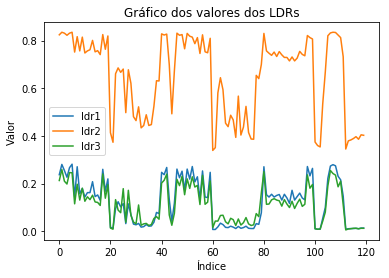

In [7]:
# Visualizando os valores obtidos nos sensores no modo gráfico

df[['ldr1', 'ldr2', 'ldr3']].plot(kind='line')
plt.title('Gráfico dos valores dos LDRs')
plt.xlabel('Índice')
plt.ylabel('Valor')

plt.show()

# Observe nos gráficos que temos um problema de escala entre as leituras dos sensores.

In [8]:
#ETAPA DE PREPARAÇÃO DE DADOS PARA ML 
# (tentando atribuir  escalas iguais nos sensores de 0 a 1 para cada sensor)
# normalizando os dados das colunas (sensores) dividindo pelo valor máximo de cada coluna (sensor)



# Crie uma instância do MinMaxScaler
scaler = MinMaxScaler()

# Seus dados originais das colunas dos LDRs
dados_ldr = data_matrix[:, :3]  # Supondo que 'data_matrix' seja a matriz que contém seus dados

# Aplique a normalização às colunas dos LDRs
dados_ldr_normalizados = scaler.fit_transform(dados_ldr)

# Supondo que 'scaler' já foi ajustado aos seus dados
valores_maximos_colunas = scaler.data_max_  

#armazena e mostra os valores máximos utilizados
valor_maximo_ldr1 = valores_maximos_colunas[0]
valor_maximo_ldr2 = valores_maximos_colunas[1]
valor_maximo_ldr3 = valores_maximos_colunas[2]

print("Valor máximo ldr1: " + str(valor_maximo_ldr1))
print("Valor máximo ldr2: " + str(valor_maximo_ldr2))    
print("Valor máximo ldr3: " + str(valor_maximo_ldr3))
    
# Substitua as colunas originais com os dados normalizados
data_matrix[:, :3] = dados_ldr_normalizados # Preenchendo as 3 primeiras colunas com dados normalizados

# Preenchendo o dataframe com dados normalizados

df = pd.DataFrame(data_matrix,columns=colunas) #dataframe com dados normalizados
print(df.head(40))


Valor máximo ldr1: 0.2815
Valor máximo ldr2: 0.8348
Valor máximo ldr3: 0.259
         ldr1       ldr2       ldr3  botao
0     0.83924   0.978208   0.818649    dia
1    0.996346          1          1    dia
2    0.903544   0.992131   0.807191    dia
3    0.800146   0.974374   0.760569    dia
4    0.946657   0.992131   0.949822    dia
5           1          1   0.946266    dia
6    0.496529   0.832324    0.43224    dia
7    0.960906    0.96247   0.757013    dia
8    0.546584   0.842211   0.494271    dia
9    0.628791   0.958636   0.691031    dia
10   0.496529   0.824455   0.474911    dia
11   0.564487   0.842211     0.5484    dia
12   0.564487   0.852098   0.501778    dia
13   0.732189   0.930993   0.575267    dia
14   0.503836   0.834342   0.463453    dia
15   0.528681   0.844229   0.455551    dia
16   0.446474   0.810734   0.405373    dia
17   0.921447   0.980226   0.926906    dia
18   0.585678   0.855932   0.525089    dia
19   0.774936   0.968523   0.749111    dia
20   0.032152   0.14

/Users/herculesborgesrodrigues/anaconda3/envs/py35duino/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


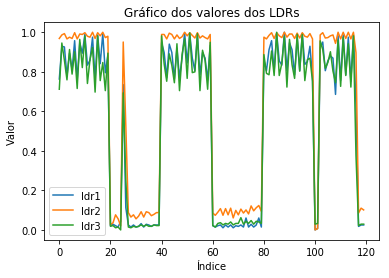

In [9]:
# Visualização dos dados normalizados
df[['ldr1', 'ldr2', 'ldr3']].plot(kind='line')
plt.title('Gráfico dos valores dos LDRs')
plt.xlabel('Índice')
plt.ylabel('Valor')

plt.show()

#observe que agora as escalas foram ajustadas para os sensores

In [9]:
# TREINAMENTO DO MODELO para fazer previsões (Dia ou Noite?) modelos binários
# 


# Seus dados, onde X são os valores dos LDRs e y é o dia/noite
X = df[['ldr1', 'ldr2', 'ldr3']]
y = df['botao']

# Dividir os dados em conjuntos de treinamento e teste. Usando 20% para teste (teste_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Inicializar e treinar o modelo RandomForestClassifier (configuração padrão)
model = RandomForestClassifier()
model.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
# AVALIAÇÃO DO MODELO

#previsões do modelo

y_pred = model.predict(X_test)

# Acurácia
accuracy = accuracy_score(y_test, y_pred)
print("Acurácia do modelo: {:.2f}%".format(accuracy * 100))

# Matriz de Confusão
conf_matrix = confusion_matrix(y_test, y_pred)
print("Matriz de Confusão:")
print(conf_matrix)

Acurácia do modelo: 83.33%
Matriz de Confusão:
[[11  2]
 [ 2  9]]


In [12]:
# FAZER PREVISÕES (TOMADA DE DECISÃO BASEADA NO MODELO) E AGIR 

# Inicializar um vetor para armazenar os dados lidos dos sensores
dados_lidos = []

try:
    while True:
        # Ler valores dos sensores (com normalização pelos valores máximos)
        
        ldr1_valor = placa.analog[ldr1].read()/valor_maximo_ldr1
        ldr2_valor = placa.analog[ldr2].read()/valor_maximo_ldr2
        ldr3_valor = placa.analog[ldr3].read()/valor_maximo_ldr3         

        # Certifique-se de que ldr1_valor, ldr2_valor e ldr3_valor não sejam None antes de armazená-los
        if ldr1_valor is not None and ldr2_valor is not None and ldr3_valor is not None:
            # Adicionar os valores ao vetor de dados lidos
            dados_lidos.append([ldr1_valor, ldr2_valor, ldr3_valor])
            print('Valores: LDR1 = {:.3f}, LDR2 = {:.3f}, LDR3 = {:.3f}'.format(ldr1_valor, ldr2_valor, ldr3_valor))

            # Fazer previsão com base nos dados lidos até agora (linha após linha)
            previsao = model.predict([dados_lidos[-1]])  # Use o modelo para fazer previsões
            print('Previsão:', previsao)
            # Determinar a posição do servo com base na previsão
            if previsao == 'dia':
                    meu_servo.write(0)  # Abra as cortinas, hora de acordar, :( , desligue as lâmpadas
            elif previsao == 'noite':
                    meu_servo.write(180)  # Feche as cortinas, hora de dormir, :) , ligue as lâmpadas
                    
            dados_lidos = []  # Limpar os dados para a próxima rodada de previsões
            
            
        # Contagem regressiva e informação ao usuário
            for i in range(10, 0, -1):  # Contagem regressiva de 10 segundos até 1 segundo
                print('Próxima leitura em {} segundos'.format(i))
                time.sleep(1)

except KeyboardInterrupt:
    # Encerrar a comunicação com o Arduino ao sair do programa
    board.exit()


Valores: LDR1 = 0.712, LDR2 = 0.984, LDR3 = 0.853
Previsão: ['dia']
Próxima leitura em 10 segundos
Próxima leitura em 9 segundos
Próxima leitura em 8 segundos
Próxima leitura em 7 segundos
Próxima leitura em 6 segundos
Próxima leitura em 5 segundos
Próxima leitura em 4 segundos
Próxima leitura em 3 segundos
Próxima leitura em 2 segundos
Próxima leitura em 1 segundos
Valores: LDR1 = 0.125, LDR2 = 0.540, LDR3 = 0.079
Previsão: ['noite']
Próxima leitura em 10 segundos
Próxima leitura em 9 segundos
Próxima leitura em 8 segundos
Próxima leitura em 7 segundos
Próxima leitura em 6 segundos
Próxima leitura em 5 segundos
Próxima leitura em 4 segundos
Próxima leitura em 3 segundos
Próxima leitura em 2 segundos
Próxima leitura em 1 segundos
Valores: LDR1 = 0.708, LDR2 = 0.968, LDR3 = 0.729
Previsão: ['dia']
Próxima leitura em 10 segundos
Próxima leitura em 9 segundos
Próxima leitura em 8 segundos
Próxima leitura em 7 segundos
Próxima leitura em 6 segundos
Próxima leitura em 5 segundos
Próxima lei

NameError: name 'board' is not defined